<a href="https://colab.research.google.com/github/dgscharan/Computer_vision/blob/main/keras_functional_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import imutils 
import matplotlib.pyplot as plt 



In [ ]:
import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, BatchNormalization, Convolution2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, concatenate, UpSampling2D, Conv2DTranspose

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot


from google.colab.patches import cv2_imshow

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


**Generate combined images test data **

In [ ]:
max = 9
def create_numbers(numbers, number_labels, maxlength=max, digit_sz=(28, 28), return_label=False):
    # Attention: Only coded to work with grayscale images at the moment.

    # Randomly choose a number length:
    img_len = np.random.choice(range(maxlength)) + 1
    label = np.empty(maxlength, dtype='str')

    #print "length: ", img_len


    # Randomly choose where in our image the sequence of numbers will appear
    if img_len < maxlength:
        st_point = np.random.choice(maxlength - img_len)
    else:
        st_point = 0
    
    #print "start:", st_point

    charmap = np.zeros(maxlength)
    charmap[st_point:st_point + img_len] = 1
    
    #print "charmap: ", charmap

    # Define a blank character - this will ensure our input image always have the same dimensions
    blank_char = np.zeros_like(digit_sz)
    blank_lbl = "."

    # Initialize a blank image with maxlen * digit_dz width and digit_sz height
    new_img_len = maxlength * digit_sz[1]
    new_img = np.zeros((digit_sz[0], new_img_len))
    
    # Fill in the image with random numbers from dataset, starting at st_point
    for i, b in enumerate(charmap):
        if b > 0:
            n = np.random.choice(len(numbers))
            st_pos = i * digit_sz[1]
            new_img[:, st_pos:st_pos + digit_sz[1]] = numbers[n]
            label[i] = str(number_labels[n])
        else:
            label[i] = blank_lbl

    if return_label:
        return new_img, label

    return new_img

In [ ]:
img, label = create_numbers(x_train, y_train, return_label = True)
cv2_imshow(img)
print(label)

['.' '.' '.' '.' '6' '6' '7' '3' '.']


In [ ]:
def generator(numbers, number_labels, batch_size=32):
    """
    This generator receives mnist digits and labels and returns a batch for training

    Input:
    numbers - array with mnist images.
    number_labels - array with mnist labels.

    Arguments:
    batch_size - size of the mini batch

    Output:
    X_train and y_train
    """
    while True:  # Loop forever so the generator never terminates

        images = []
        labels = []

        for batch_sample in range(batch_size):
            img, label = create_numbers(numbers, number_labels, return_label=True)
            
            # Here we will convert the label to a format that Keras API can process:
            n_label = np.zeros((max, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n_digit = 10
                else:
                    n_digit = int(digit)

                n_label[i][n_digit] = 1
                

            images.append(img)
            #labels.append(label)
            labels.append(n_label)

        X_train = np.array(images)
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, -1)

        y_temp = np.array(labels)
        
        y1 = y_temp[:, 0, :]
        y2 = y_temp[:, 1, :]
        y3 = y_temp[:, 2, :]
        y4 = y_temp[:, 3, :]
        y5 = y_temp[:, 4, :]
        y6 = y_temp[:, 5, :]
        y7 = y_temp[:, 6, :]
        y8 = y_temp[:, 7, :]
        y9 = y_temp[:, 8, :]

        yield X_train, [y1, y2, y3, y4, y5,y6,y7,y8,y9]

In [ ]:
def convert_label(label):
    n_label = ""
    for digit in label:
        if np.argmax(digit) == 10:
            n_digit = "."
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

In [ ]:
# Create samples to test the generator
i = 0
for a, b in generator(x_train, y_train, batch_size=16): 
    test_imgs = a
    test_lbls = b
    
    i += 1
    
    if i > 1:
        break

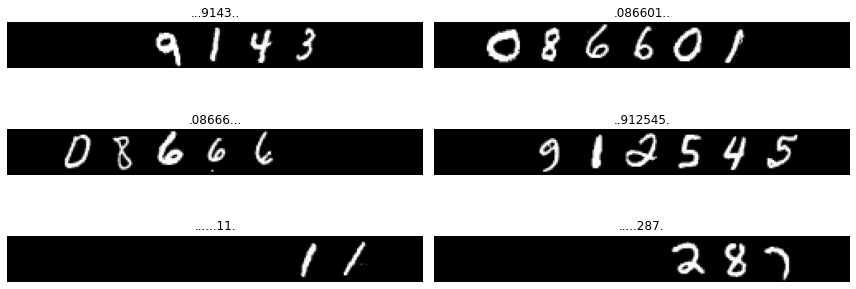

In [ ]:
rows_to_plot = 8
cols_to_plot = 2

f = plt.figure(figsize=(12, 12))

for i in range(6):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title(convert_label(np.vstack((test_lbls[0][i], test_lbls[1][i], test_lbls[2][i], 
                                                test_lbls[3][i],test_lbls[4][i],test_lbls[5][i],test_lbls[6][i],test_lbls[7][i],test_lbls[8][i]))))
    plt.imshow(test_imgs[i][:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

# Based on Model from: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf
def get_model(input_shape=(28, 28*max, 3), p=0.5, n_class=11):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    # I had to remove this part because the input size we have is too small for a network this deep.
    # Another alternative would have been change the maxpool strides.
    
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    #x = Dropout(p)(x)

    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    #x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x) # I also reduced the number of activations
    x = Dense(1024, activation='relu')(x)
    
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    c6 = Dense(n_class, activation='softmax')(x)
    c7 = Dense(n_class, activation='softmax')(x)
    c8 = Dense(n_class, activation='softmax')(x)
    c9 = Dense(n_class, activation='softmax')(x)


    
    output = [c1, c2, c3, c4, c5,c6,c7,c8,c9]
    
    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
def convert_output(model_output):
    model_output = np.array(model_output).swapaxes(0,1)
    labels = []
    for output in model_output:
        label = convert_label(output)
        labels.append(label)
    return labels

In [ ]:
model = get_model(input_shape=(28,28*max,1))


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 252, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 252, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 252, 48)  1248        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 126, 48)  0           conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
optimizer = Adam(lr = 1e-3)
model.compile(optimizer, loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

trn_generator = generator(x_train, y_train, batch_size=128)
val_generator = generator(x_test, y_test, batch_size=128)

In [ ]:
model.fit_generator(trn_generator,
                    epochs=5,
                    steps_per_epoch=780,
                    validation_data=val_generator,
                    validation_steps=780,
                    verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
780/780 [==============================] - 108s 139ms/step - loss: 3.4604 - dense_2_loss: 0.3241 - dense_3_loss: 0.3958 - dense_4_loss: 0.4614 - dense_5_loss: 0.4780 - dense_6_loss: 0.4817 - dense_7_loss: 0.4510 - dense_8_loss: 0.4013 - dense_9_loss: 0.3027 - dense_10_loss: 0.1643 - dense_2_categorical_accuracy: 0.8892 - dense_3_categorical_accuracy: 0.8616 - dense_4_categorical_accuracy: 0.8398 - dense_5_categorical_accuracy: 0.8326 - dense_6_categorical_accuracy: 0.8320 - dense_7_categorical_accuracy: 0.8414 - dense_8_categorical_accuracy: 0.8612 - dense_9_categorical_accuracy: 0.8967 - dense_10_categorical_accuracy: 0.9505 - val_loss: 0.3121 - val_dense_2_loss: 0.0202 - val_dense_3_loss: 0.0372 - val_dense_4_loss: 0.0442 - val_dense_5_loss: 0.0420 - val_dense_6_loss: 0.0370 - val_dense_7_loss: 0.0348 - val_dense_8_loss: 0.0483 - val_dense_9_loss: 0.0275 - val_dense_10_loss: 0.0209 - val_dense_2_cat

In [ ]:
i= 0
for test_set, test_labels in generator(x_train, y_train, batch_size=1000):
    i += 1
    if i > 1:
        break

In [ ]:
model.evaluate(test_set, test_labels)

32/32 [==============================] - 1s 22ms/step - loss: 0.0674 - dense_2_loss: 0.0063 - dense_3_loss: 0.0353 - dense_4_loss: 0.0033 - dense_5_loss: 3.2370e-04 - dense_6_loss: 0.0103 - dense_7_loss: 9.5953e-04 - dense_8_loss: 0.0091 - dense_9_loss: 0.0018 - dense_10_loss: 5.5603e-05 - dense_2_categorical_accuracy: 0.9980 - dense_3_categorical_accuracy: 0.9980 - dense_4_categorical_accuracy: 0.9990 - dense_5_categorical_accuracy: 1.0000 - dense_6_categorical_accuracy: 0.9980 - dense_7_categorical_accuracy: 1.0000 - dense_8_categorical_accuracy: 0.9970 - dense_9_categorical_accuracy: 0.9990 - dense_10_categorical_accuracy: 1.0000


[0.06740207225084305,
 0.00628602085635066,
 0.03531826287508011,
 0.003308018436655402,
 0.00032369798282161355,
 0.010254614055156708,
 0.0009595284936949611,
 0.009146134369075298,
 0.0017501848051324487,
 5.560261706705205e-05,
 0.9980000257492065,
 0.9980000257492065,
 0.9990000128746033,
 1.0,
 0.9980000257492065,
 1.0,
 0.996999979019165,
 0.9990000128746033,
 1.0]

In [ ]:
model.save('./9digit.h5')

In [ ]:

img = cv2.imread('6_1.jpg', 0)# Read the image
(thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)#Thresholding the image
img_bin = 255-img_bin

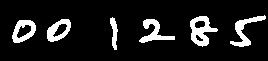

In [ ]:
cv2_imshow(img_bin)

In [ ]:
#======================= sort_contours ===========================================
def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0

        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
                reverse = True

        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
                i = 1

        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                key=lambda b:b[1][i], reverse=reverse))

        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)
#==================================================================================


def box_extraction(img_for_box_extraction_path, cropped_dir_path):
        img = cv2.imread(img_for_box_extraction_path, 0)# Read the image
        (thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)#Thresholding the image
        img_bin = 255-img_bin# Invert the image
        #cv2_imshow(img_bin)
        #cv2.imwrite("inter_processing/Image_bin.jpg",img_bin)

        # Defining a kernel length
        kernel_length = np.array(img).shape[1]//40

        # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
        verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))

        # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
        hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

        # A kernel of (3 X 3) ones.
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

        # Morphological operation to detect verticle lines from an image
        img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
        verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
        #cv2.imwrite("inter_processing/verticle_lines.jpg",verticle_lines_img)
        #cv2_imshow(verticle_lines_img)

        # Morphological operation to detect horizontal lines from an image
        img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
        horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
        #cv2.imwrite("inter_processing/horizontal_lines.jpg",horizontal_lines_img)
        #cv2_imshow(horizontal_lines_img)

        # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
        alpha = 0.5
        beta = 1.0 - alpha

        # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
        img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
        img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
        (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # For Debugging
        # Enable this line to see verticle and horizontal lines in the image which is used to find boxes
        #cv2.imwrite("inter_processing/img_final_bin.jpg",img_final_bin)
        #cv2_imshow(img_final_bin)

        # Find contours for image, which will detect all the boxes
        contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Sort all the contours by top to bottom.
        (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
        idx = 0
        for c in contours:
                # Returns the location and width,height for every contour
                x, y, w, h = cv2.boundingRect(c)

                # If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
                if (w > 50 and h > 15) and w > 2*h:
                        idx += 1
                        new_img = img[y:y+h, x:x+w]
                        new_img=~new_img
                        (thresh, new_img) = cv2.threshold(new_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
                        cv2_imshow(new_img)
                        arr.append(new_img)
box_extraction("job_num.jpg", "./Cropped/") #image to be extracted, directory where to save cropped images

In [ ]:
a=[]
for x in range(0,22):
    a.append(cv2.resize(arr[x], (168,28), interpolation=cv2.INTER_CUBIC))
    cv2_imshow(a[x])

IndexError: ignored